In [21]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

1. Lage en tom testmappe i data mappen.
2. Legge til MURAv1.1 med train og valid mappene i data mappen.(kan slette de csv filene som følger med i MURA-v1.1) 
3. Kjøre scriptet "renaming_and_move_test_files"
4. Kjøre notebooken (edited)

# MURA

In [22]:
import sys
import os.path
sys.path.append("../../fastai/")

In [23]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn.metrics import confusion_matrix

In [24]:
# See how many devices are around
torch.cuda.device_count()
# Set it to a particular device
torch.cuda.set_device(0)
# Check which device you are on
torch.cuda.current_device()

0

In [25]:
NB_DIR = %pwd
PATH = f'{NB_DIR}/data/'

In [26]:
cleaned_label_path = f'{PATH}new_cleaned_label.csv'

In [27]:
os.path.isfile(cleaned_label_path)

True

 # Hopp til load cleanled label hvis filen finnes fra før av

In [ ]:
df_train_image_paths = pd.read_csv(f'{PATH}train_image_paths.csv',header=None)
df_train_labeled_studies = pd.read_csv(f'{PATH}train_labeled_studies.csv', header=None)

In [ ]:
df_train_image_paths.columns = ['Image Index']

In [ ]:
df_train_labeled_studies.columns = ['Image Index', 'Abnormality']

In [ ]:
#finne indeksen 
df_train_image_paths['Abnormality'] = np.nan

In [ ]:
total = 0; 
for index, row in df_train_labeled_studies.iterrows():
    studie_name = row['Image Index']
    studie_abnormality = row['Abnormality']
    
    df = df_train_image_paths['Image Index'].str.contains(studie_name)
    df = df[df]
    idx_list = list(df.index)
    df_train_image_paths.loc[idx_list, 'Abnormality'] = studie_abnormality      
    total = total + len(idx_list);

In [ ]:
df_train_image_paths.shape, total

In [ ]:
df_train_image_paths.head()

In [ ]:
df_sorted = df_train_image_paths.pivot_table(index='Abnormality', aggfunc=len).sort_values('Image Index') 
df_sorted['Image Index'].plot(kind='bar', title="Normal vs abnormal")

In [ ]:
df_train_image_paths.to_csv(cleaned_label_path, index=False)

# Load cleaned label

In [28]:
df_train_image_paths = pd.read_csv(cleaned_label_path)

In [29]:
n = len(df_train_image_paths)-1
val_idxs = get_cv_idxs(n, val_pct=0.15) 

In [30]:
len(val_idxs)

5051

In [31]:
df_train_image_paths.shape

(33676, 2)

# View data

In [50]:
sz = 64
arch = dn121
bs = 32

In [51]:
#aug_tfms = [RandomLighting(b=0, c=8), RandomFlip()]
def get_data(sz): 
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
  #transforms_side_on
    return ImageClassifierData.from_csv(PATH ,'', cleaned_label_path , test_name='test', tfms=tfms, bs=bs, val_idxs = val_idxs);

In [52]:
data = get_data(sz)

In [53]:
fn = PATH+data.trn_ds.fnames[10]

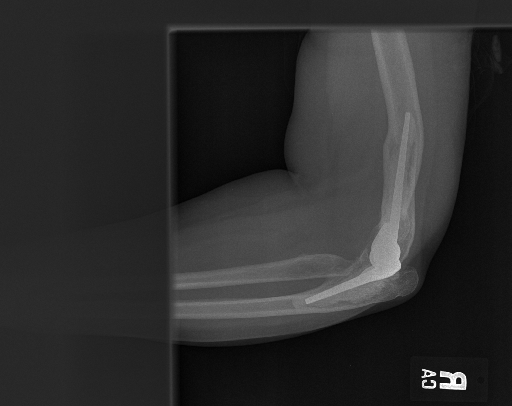

In [54]:
img = PIL.Image.open(fn);
img

In [55]:
data.trn_ds.fnames.shape ,data.val_ds.fnames.shape

((28625,), (5051,))

# Training (hopp til prediction on test set)

In [56]:
learn = ConvLearner.pretrained(arch, data, ps = 0.4, opt_fn=optim.Adam) 

 71%|███████   | 631/895 [00:23<00:09, 26.95it/s, loss=2.6]  

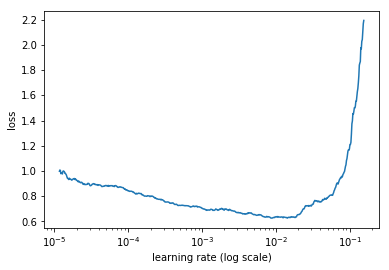

 71%|███████   | 631/895 [00:36<00:15, 17.18it/s, loss=2.6]

In [57]:
learn.lr_find()
learn.sched.plot()

In [58]:
lr = 0.001

In [59]:
learn.fit(lr,2, cycle_len=1, cycle_mult=2) 

epoch      trn_loss   val_loss   accuracy                    
    0      0.545216   0.487815   0.768561  
    1      0.518956   0.476062   0.779648                    
    2      0.490942   0.464313   0.787369                    


[array([0.46431]), 0.7873688380072976]

In [60]:
lrs = [lr/9, lr/3, lr] #TODO uten TL bør jeg dele på 9 og 3
learn.unfreeze()

In [61]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}dn121')

epoch      trn_loss   val_loss   accuracy                    
    0      0.410509   0.3832     0.836864  
    1      0.398014   0.351264   0.852108                    
    2      0.350088   0.332257   0.859434                    


In [62]:
sz = 128

In [63]:
learn.set_data(get_data(sz))
learn.freeze()

In [64]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.353541   0.346782   0.856266  
    1      0.366948   0.337503   0.857256                    
    2      0.370439   0.332493   0.862206                    


[array([0.33249]), 0.8622055038960234]

In [65]:
learn.unfreeze();
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.328902   0.298707   0.8824    
    1      0.321068   0.291504   0.887151                    
    2      0.28931    0.266631   0.895466                    


[array([0.26663]), 0.8954662442254538]

In [66]:
learn.save(f'{sz}dn121')

In [67]:
sz = 299

In [68]:
learn.set_data(get_data(sz))
learn.freeze() 

In [69]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.352412   0.328185   0.863393  
    1      0.329516   0.321653   0.862403                    
    2      0.33271    0.312705   0.871313                    


[array([0.3127]), 0.871312611399488]

In [70]:
learn.unfreeze()
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.31461    0.270153   0.890517  
    1      0.303943   0.273198   0.886557                    
    2      0.248016   0.240754   0.906751                    


[array([0.24075]), 0.9067511384238396]

In [71]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}aug2')

epoch      trn_loss   val_loss   accuracy                    
    0      0.261465   0.234365   0.906553  
    1      0.27987    0.246406   0.903385                    
    2      0.227659   0.228975   0.909127                    


In [72]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}aug3')

epoch      trn_loss   val_loss   accuracy                    
    0      0.226708   0.230093   0.906157  
    1      0.273134   0.265764   0.891309                    
    2      0.193674   0.225884   0.912295                    


# Prediction on test set

In [150]:
sz = 299
data = get_data(sz)
learn = ConvLearner.pretrained(arch, data, ps = 0.4, opt_fn=optim.Adam) 
learn.load("299aug3")

In [151]:
df_test = pd.read_csv(f'{PATH}valid_image_paths.csv', header=None)
df_test.columns = ['Image Index']

In [152]:
len(data.test_ds.fnames)

3197

In [153]:
df_test.head()

,Image Index
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...


In [154]:
df_test.shape

(3197, 1)

In [155]:
df_test['Image Index'] = df_test['Image Index'].str.replace("MURA-v1.1/valid","test")
df_test['Image Index'] = df_test['Image Index'].str.replace("/", "_")
df_test['Image Index'] = df_test['Image Index'].str.replace("test_","test/")

In [156]:
patient_study_idxs = {}
for stud in df_test['Image Index']:
    study_name = stud[:-11]  #eksempel: studyname = test/XR_FOREARM_patient12044_study1_positive
    if study_name not in patient_study_idxs: 
        indices = [i for i, s in enumerate(data.test_ds.fnames) if study_name in s] #posisjonen til alle som 
        patient_study_idxs[study_name] = indices

In [157]:
len(patient_study_idxs)

1200

In [158]:
patient_study_y_label = {}
for key, value in patient_study_idxs.items():
    y_string = ([x.strip() for x in key.split('_')][-1])
    y=0
    if y_string == 'positive': y=1
    patient_study_y_label[key] = y

### Predict studies 

In [159]:
trn_tfms, val_tfms = tfms_from_model(arch, sz) # get transformations
def predict_abnormality(fn): 
    im = open_image(fn)
    im_val = val_tfms(im)
    preds = learn.predict_array(im_val[None])
    return np.argmax(preds)

In [160]:
#value inneholder alle indeksene til et studie 
study_prediction_dict = {}
for key, value in patient_study_idxs.items(): 
    prediction_list = []    
    for img_pos in value: 
        prediction = predict_abnormality(PATH+data.test_ds.fnames[img_pos])
        prediction_list.append(prediction)
    study_prediction_dict[key] = max(prediction_list)

In [161]:
num_correct = 0;
wrong_prediction = {}
correct_prediction = {}
for key, value in study_prediction_dict.items(): 
    xr_type = ([x.strip() for x in key.split('_')][1]) #finne riktig 
    y = patient_study_y_label[key]
    if value == y: 
        num_correct +=1
        if xr_type not in correct_prediction: 
            correct_prediction[xr_type] = 1
        else: correct_prediction[xr_type] +=1
    else: 
        if xr_type  not in wrong_prediction: 
            wrong_prediction[xr_type] = 1
        else:wrong_prediction[xr_type] +=1

In [162]:
test_accuracy = num_correct/len(study_prediction_dict)

In [163]:
print("case study accuracy: "+str(test_accuracy))

case study accuracy: 0.8416666666666667


In [164]:
correct_prediction

{'WRIST': 208,
 'FOREARM': 114,
 'HAND': 139,
 'HUMERUS': 116,
 'SHOULDER': 155,
 'ELBOW': 136,
 'FINGER': 142}

In [165]:
wrong_prediction

{'WRIST': 29,
 'FOREARM': 20,
 'HAND': 28,
 'HUMERUS': 19,
 'SHOULDER': 39,
 'ELBOW': 22,
 'FINGER': 33}

In [166]:
cm = confusion_matrix(list(patient_study_y_label.values()),list(study_prediction_dict.values()));

[[585  77]
 [113 425]]


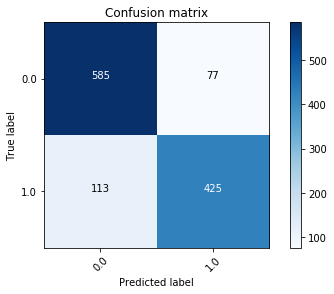

In [167]:
plot_confusion_matrix(cm, data.classes)

In [168]:
def cat_pred(correct, total): 
    return correct/total

In [169]:
for key,value in correct_prediction.items(): 
    total = value + wrong_prediction[key]
    acc = cat_pred(value, total)
    print("Accuracy for: " + key + ": " + str(acc) + "%")

Accuracy for: WRIST: 0.8776371308016878%
Accuracy for: FOREARM: 0.8507462686567164%
Accuracy for: HAND: 0.8323353293413174%
Accuracy for: HUMERUS: 0.8592592592592593%
Accuracy for: SHOULDER: 0.7989690721649485%
Accuracy for: ELBOW: 0.8607594936708861%
Accuracy for: FINGER: 0.8114285714285714%
